# Space X Falcon 9 First Stage Landing Prediction

This notebook creates a machine learning pipeline to predict the landing outcome of the Falcon 9 first stage based on various launch parameters.

Features:
- Data preprocessing and standardization
- Training and test data split
- Hyperparameter tuning for multiple classification algorithms
- Model performance evaluation
- Comparison of different machine learning models

## 1. Setup

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, jaccard_score, f1_score
from sklearn.inspection import permutation_importance

# Constants
DATA_URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
DATA_URL2 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv"

## 2. Define Helper Functions

In [28]:
def plot_confusion_matrix(y, y_predict):
    """
    Creates and displays a heatmap visualization of the confusion matrix,
    showing the comparison between true labels and predicted labels for a binary
    classification problem.
    """

    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='d')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Did Not Land', 'Landed'])
    ax.yaxis.set_ticklabels(['Did Not Land', 'Landed'])
    plt.show()

## 3. Data Loading

In [29]:
# Load data
data = pd.read_csv(DATA_URL1)
X = pd.read_csv(DATA_URL2)

print("Data loaded successfully.")
display(data.head())
display(X.head())

# Store feature names
feature_names = X.columns.tolist()

Data loaded successfully.


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## 4. Data Preprocessing

In [30]:
# TASK 1: Create target variable
Y = data['Class'].to_numpy()

# TASK 2: Standardize the data
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

# TASK 3: Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(f"Shape of test set: {Y_test.shape}")

Shape of test set: (27,)


## 5. Validate and Compare Models

In [31]:
# Define stratified k-fold validation strategy
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

### TASK 4: Logistic Regression

In [32]:
parameters = {'C': [0.01, 0.1, 1], 'penalty': ['l2'], 'solver': ['lbfgs']}

lr = LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=stratified_cv)
logreg_cv.fit(X_train, Y_train)

print("Logistic Regression results:")
print(f"Best parameters: {logreg_cv.best_params_}")
print(f"Best score: {logreg_cv.best_score_}")

Logistic Regression results:
Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.7928571428571428


### TASK 5: Logistic Regression Evaluation

Logistic Regression Test Accuracy: 0.8888888888888888


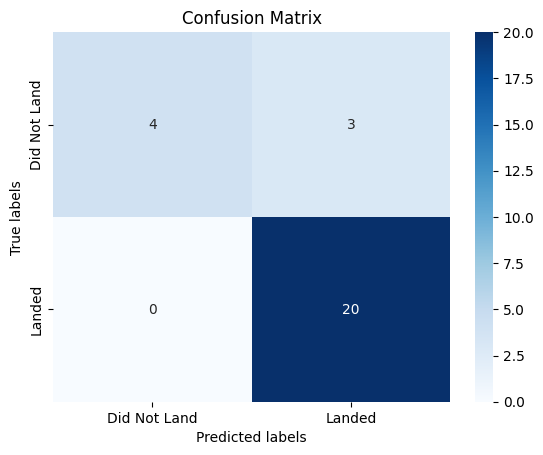

In [33]:
logreg_accuracy = logreg_cv.score(X_test, Y_test)
print(f"Logistic Regression Test Accuracy: {logreg_accuracy}")

yhat_lr = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat_lr)

### TASK 6: Support Vector Machine

In [34]:
parameters = {'kernel': ('linear', 'rbf', 'poly', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma': np.logspace(-3, 3, 5)}

svm = SVC(probability=True)
svm_cv = GridSearchCV(svm, parameters, cv=stratified_cv)
svm_cv.fit(X_train, Y_train)

print("Support Vector Machine results:")
print(f"Best parameters: {svm_cv.best_params_}")
print(f"Best score: {svm_cv.best_score_}")

Support Vector Machine results:
Best parameters: {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Best score: 0.8071428571428572


### TASK 7: SVM Evaluation

SVM Test Accuracy: 0.8888888888888888


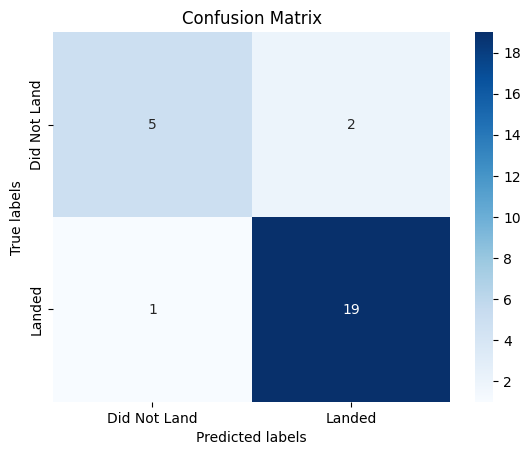

In [35]:
svm_accuracy = svm_cv.score(X_test, Y_test)
print(f"SVM Test Accuracy: {svm_accuracy}")

yhat_svm = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat_svm)

### TASK 8: Decision Tree

In [36]:
parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [2*n for n in range(1, 10)],
              'max_features': ['sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv=stratified_cv)
tree_cv.fit(X_train, Y_train)

print("Decision Tree results:")
print(f"Best parameters: {tree_cv.best_params_}")
print(f"Best score: {tree_cv.best_score_}")

Decision Tree results:
Best parameters: {'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
Best score: 0.8738095238095239


### TASK 9: Decision Tree Evaluation

Decision Tree Test Accuracy: 0.7777777777777778


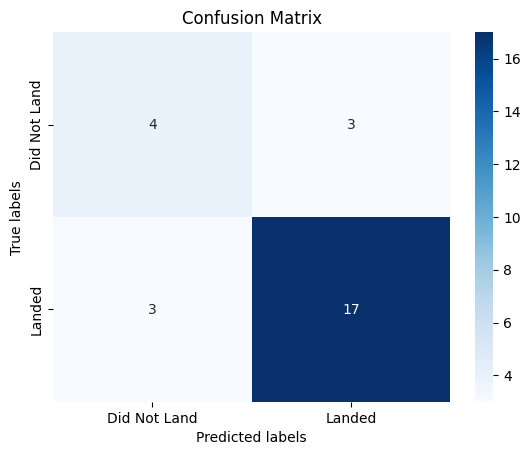

In [37]:
tree_accuracy = tree_cv.score(X_test, Y_test)
print(f"Decision Tree Test Accuracy: {tree_accuracy}")

yhat_tree = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat_tree)

### TASK 10: K-Nearest Neighbors

In [38]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2]}

KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN, parameters, cv=stratified_cv)
knn_cv.fit(X_train, Y_train)

print("K-Nearest Neighbors results:")
print(f"Best parameters: {knn_cv.best_params_}")
print(f"Best score: {knn_cv.best_score_}")

K-Nearest Neighbors results:
Best parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
Best score: 0.8404761904761905


### TASK 11: KNN Evaluation

KNN Test Accuracy: 0.9259259259259259


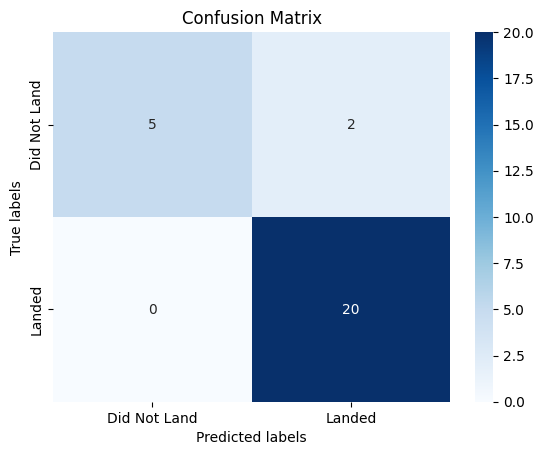

In [39]:
knn_accuracy = knn_cv.score(X_test, Y_test)
print(f"KNN Test Accuracy: {knn_accuracy}")

yhat_knn = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat_knn)

### Random Forest

In [45]:
parameters_rf = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
}

rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, parameters_rf, cv=stratified_cv)
rf_cv.fit(X_train, Y_train)

print("Random Forest results:")
print(f"Best parameters: {rf_cv.best_params_}")
print(f"Best score: {rf_cv.best_score_}")

Random Forest results:
Best parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.8428571428571429


### Random Forest Evaluation

Random Forest Test Accuracy: 0.9259259259259259


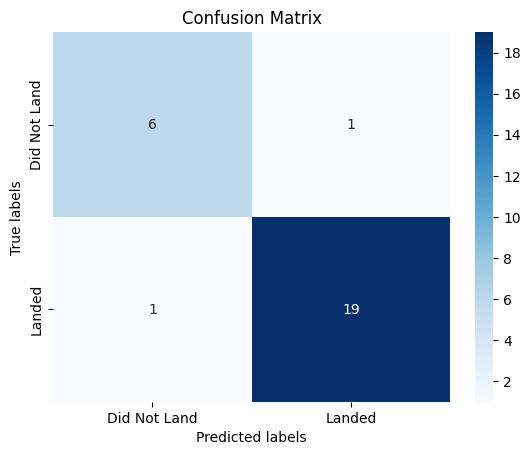

In [41]:
rf_accuracy = rf_cv.score(X_test, Y_test)
print(f"Random Forest Test Accuracy: {rf_accuracy}")

yhat_rf = rf_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat_rf)

### TASK 12: Find the best performing method

Model Performance Metrics:


,Jaccard_Score,F1_Score,Precision,Recall,ROC_AUC,Accuracy
LogReg,0.869565,0.930233,0.869565,1.00,0.842857,0.888889
SVM,0.863636,0.926829,0.904762,0.95,0.871429,0.888889
Tree,0.739130,0.850000,0.850000,0.85,0.739286,0.777778
KNN,0.909091,0.952381,0.909091,1.00,0.821429,0.925926
RandForest,0.904762,0.950000,0.950000,0.95,0.864286,0.925926



Best model for each metric:
Jaccard_Score: KNN (Score: 0.9091)
F1_Score: KNN (Score: 0.9524)
Precision: RandForest (Score: 0.9500)
Recall: LogReg (Score: 1.0000)
ROC_AUC: SVM (Score: 0.8714)
Accuracy: KNN (Score: 0.9259)


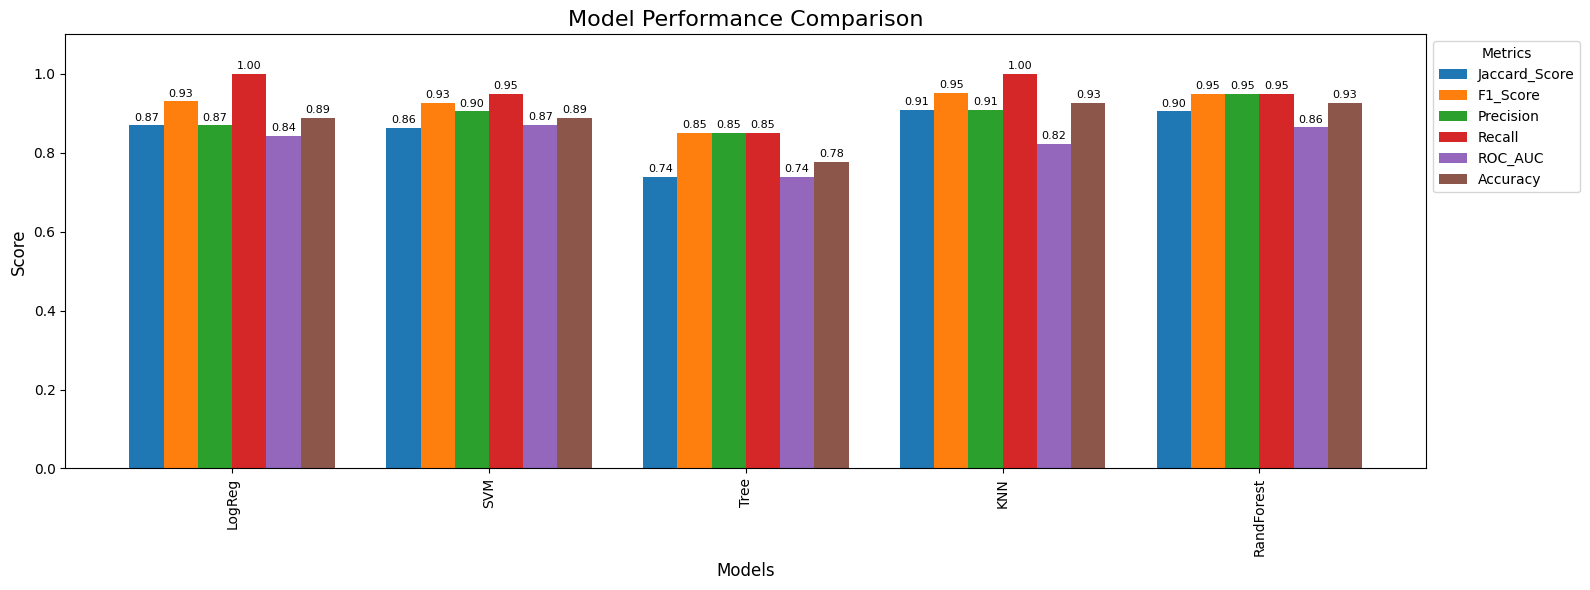

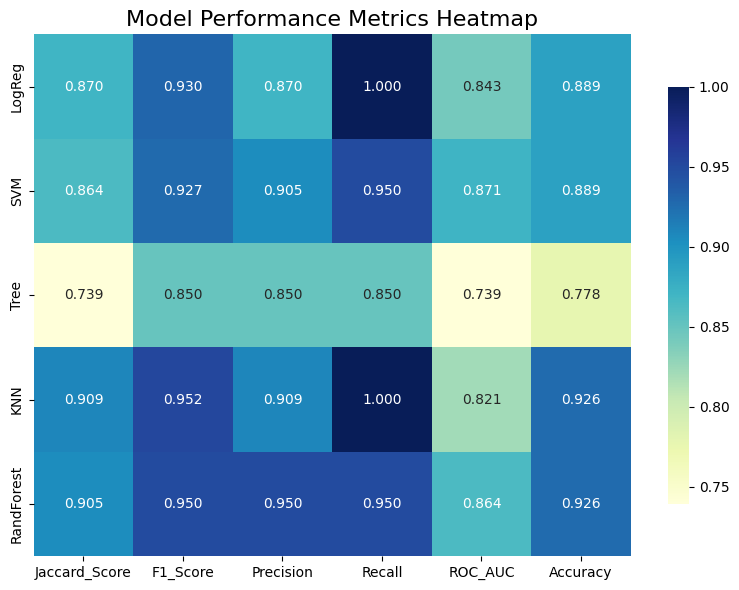


Best model based on ROC_AUC: SVM (Score: 0.8714)

Confusion Matrix for SVM:


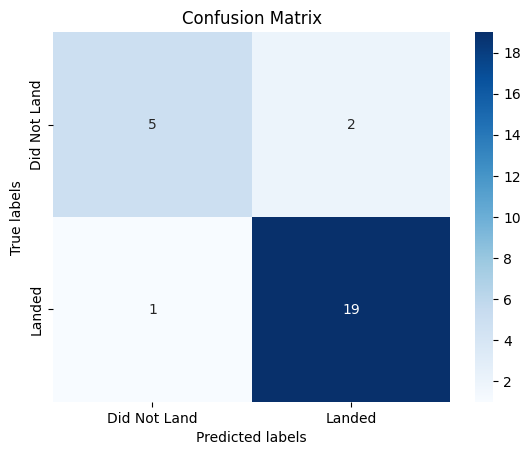

Classification Report for SVM:

              precision    recall  f1-score   support

Did Not Land       0.83      0.71      0.77         7
      Landed       0.90      0.95      0.93        20

    accuracy                           0.89        27
   macro avg       0.87      0.83      0.85        27
weighted avg       0.89      0.89      0.89        27



In [42]:
# Obtain predicted probabilities for ROC AUC calculation
yhat_proba_lr = logreg_cv.best_estimator_.predict_proba(X_test)[:, 1]
yhat_proba_svm = svm_cv.best_estimator_.predict_proba(X_test)[:, 1]
yhat_proba_tree = tree_cv.best_estimator_.predict_proba(X_test)[:, 1]
yhat_proba_knn = knn_cv.best_estimator_.predict_proba(X_test)[:, 1]
yhat_proba_rf = rf_cv.best_estimator_.predict_proba(X_test)[:, 1]

# Initialize lists to store model performance scores
jaccard_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
roc_auc_scores = []
accuracy_scores = []
model_names = []

# Prepare list of tuples with yhat, yhat_proba, and model_name
model_predictions = [
    (yhat_lr, yhat_proba_lr, 'LogReg'),
    (yhat_svm, yhat_proba_svm, 'SVM'),
    (yhat_tree, yhat_proba_tree, 'Tree'),
    (yhat_knn, yhat_proba_knn, 'KNN'),
    (yhat_rf, yhat_proba_rf, 'RandForest'),
]

for yhat, yhat_proba, model_name in model_predictions:
    jaccard_scores.append(jaccard_score(Y_test, yhat))
    f1_scores.append(f1_score(Y_test, yhat))
    precision_scores.append(precision_score(Y_test, yhat))
    recall_scores.append(recall_score(Y_test, yhat))
    roc_auc_scores.append(roc_auc_score(Y_test, yhat_proba))
    accuracy_scores.append(accuracy_score(Y_test, yhat))
    model_names.append(model_name)

# Create DataFrame with all scores
scores = pd.DataFrame({
    'Jaccard_Score': jaccard_scores,
    'F1_Score': f1_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'ROC_AUC': roc_auc_scores,
    'Accuracy': accuracy_scores
}, index=model_names)

print("Model Performance Metrics:")
display(scores)

# Identify best model for each metric
best_models = scores.idxmax()
print("\nBest model for each metric:")
for metric, model in best_models.items():
    print(f"{metric}: {model} (Score: {scores.loc[model, metric]:.4f})")

# Create model comparison plot
ax = scores.plot(kind='bar', figsize=(16, 6), width=0.8)
plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(title='Metrics', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.ylim(0, 1.1)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=2, fontsize=8)

plt.tight_layout()
plt.show()

# Additional heatmap performance visualization
plt.figure(figsize=(8, 6))
sns.heatmap(scores, annot=True, cmap='YlGnBu', fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Model Performance Metrics Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

# Determine best model based on specific metric (e.g., ROC_AUC)
best_metric = 'ROC_AUC'
best_model_name = scores[best_metric].idxmax()
print(f"\nBest model based on {best_metric}: {best_model_name} (Score: {scores.loc[best_model_name, best_metric]:.4f})")

# Get predictions for best model
best_model_predictions = {model_name: yhat for yhat, _, model_name in model_predictions}
best_yhat = best_model_predictions[best_model_name]

# Plot confusion matrix for best model using your helper function
print(f"\nConfusion Matrix for {best_model_name}:")
plot_confusion_matrix(Y_test, best_yhat)

# Print classification report for the best model
from sklearn.metrics import classification_report

print(f"Classification Report for {best_model_name}:\n")
print(classification_report(Y_test, best_yhat, target_names=['Did Not Land', 'Landed']))

## Feature Importance

Calculating feature importance for the best model: SVM

Top 10 Most Important Features for SVM:


,feature,importance
0,LandingPad_5e9e3032383ecb761634e7cb,0.055556
1,Legs_True,0.011111
2,Legs_False,0.011111
3,Serial_B1060,0.003704
4,Serial_B1059,0.003704
5,Orbit_LEO,0.003704
6,Serial_B1032,0.000000
7,Serial_B1041,0.000000
8,Serial_B1040,0.000000
9,Serial_B1038,0.000000


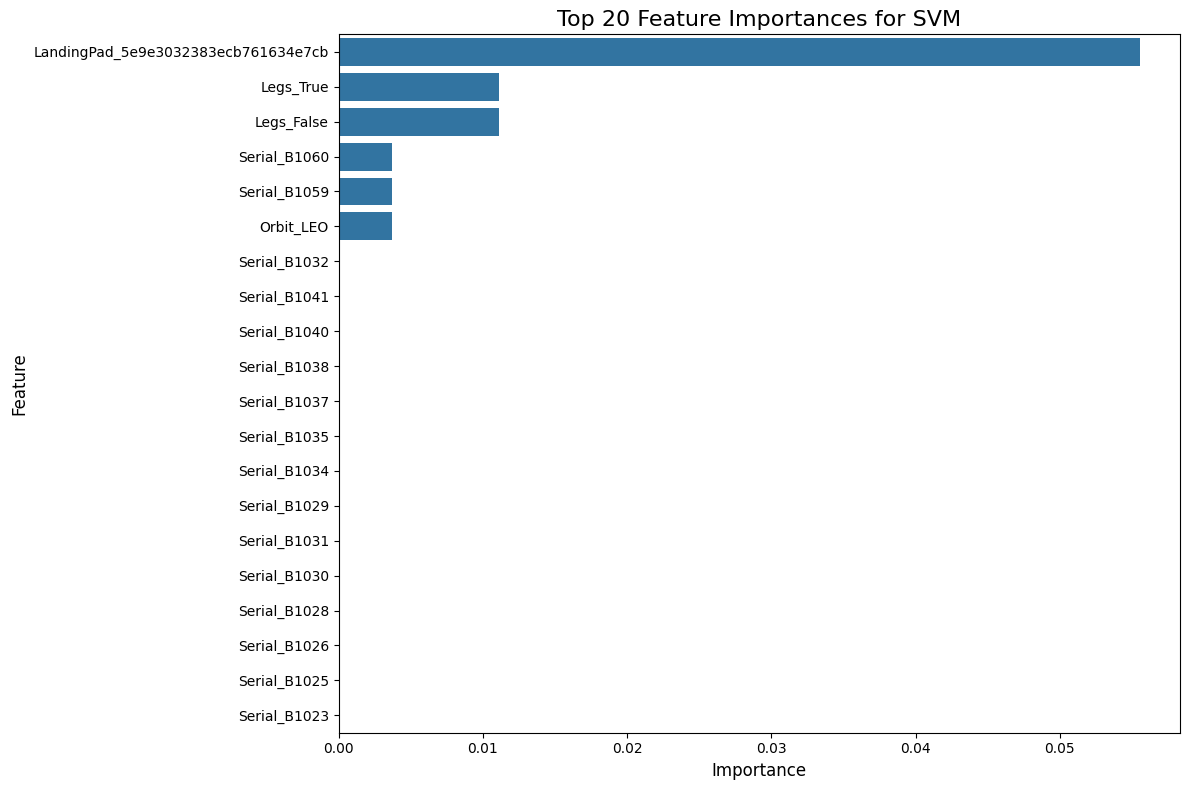

In [43]:
# Dictionary for mapping models to their estimators
model_dict = {
    'LogReg': logreg_cv.best_estimator_,
    'SVM': svm_cv.best_estimator_,
    'Tree': tree_cv.best_estimator_,
    'KNN': knn_cv.best_estimator_,
    'RandForest': rf_cv.best_estimator_
}

# Get best model
best_model = model_dict.get(best_model_name)

if best_model is not None:
    print(f"Calculating feature importance for the best model: {best_model_name}")

    # Calculate feature importance
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    else:
        perm_importance = permutation_importance(best_model, X_test, Y_test, n_repeats=10, random_state=42)
        importances = perm_importance.importances_mean

    # Create and sort feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).reset_index(drop=True)

    # Display top 10 most important features
    print(f"\nTop 10 Most Important Features for {best_model_name}:")
    display(feature_importance_df.head(10))

    # Visualize feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
    plt.title(f'Top 20 Feature Importances for {best_model_name}', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

else:
    print("Unable to calculate feature importance for the best model.")